In [1]:
import pandas as pd
from pathlib import Path
from sklearn.model_selection import ParameterGrid

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
int_cols = ['data_size', 'batch_size', 'num_runs', 'num_workers','prefetch_factor']
float_cols = [
    'memory allocated (MB)',
    'memory reserved  (MB)', 
    'max memory allocated (MB)',
    'max memory reserved  (MB)', 
    'inference time per hundred frames',
    'std'
]
bool_cols = ['pin_memory', 'benchmark']

In [5]:
# noloader
int_cols = ['data_size', 'batch_size', 'num_runs']
float_cols = [
    'memory allocated (MB)',
    'memory reserved  (MB)', 
    'max memory allocated (MB)',
    'max memory reserved  (MB)', 
    'frames per second',
    'std'
]
bool_cols = ['benchmark']

In [8]:
dfs = [pd.read_csv(csv, index_col=0).T for csv in Path('results/').glob('noloader*.csv')]
df = pd.concat(dfs).reset_index(drop=True)

# Processing data type
for cols, dtype in zip([int_cols, float_cols], ['int', 'float']):
    for col in cols:
        df[col] = df[col].astype(dtype)
for col in bool_cols:
    df[col] = df[col].map({'True': True, 'False': False})

df.to_csv('results/inference_time_noloader.csv', float_format='%.6f')
df

,data_size,batch_size,num_runs,benchmark,memory allocated (MB),memory reserved (MB),max memory allocated (MB),max memory reserved (MB),frames per second,std
0,1024,8,10,False,2989.550293,3220.0,3177.051270,3220.0,671.255709,14.268561
1,1024,4,10,False,2989.374512,3110.0,3085.375488,3110.0,607.759932,6.588305
2,1024,16,10,False,2989.901855,3442.0,3364.902832,3442.0,694.680567,27.979450
3,1024,32,10,True,2990.604980,3878.0,3736.794434,3878.0,697.295636,50.683825
4,1024,128,10,False,2994.823730,6526.0,5970.831543,6526.0,659.854159,106.867286
5,1024,32,10,False,2990.604980,3878.0,3736.794434,3878.0,692.707120,50.643815
6,1024,16,10,True,2989.901855,3442.0,3364.902832,3442.0,702.208536,28.287186
7,1024,2,10,False,2989.286621,3058.0,3036.537598,3058.0,511.572952,2.809006
8,1024,8,10,True,2989.550293,3220.0,3177.051270,3220.0,676.688736,14.970345
9,1024,2,10,True,2989.286621,3058.0,3036.537598,3058.0,517.398709,2.554176


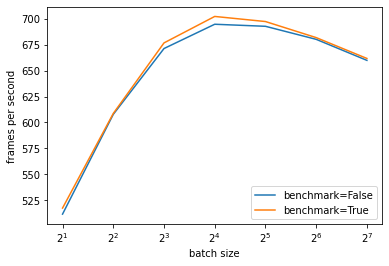

In [13]:
def query(df, params, targets=None):
    for key in params:
        if params[key] is None:
            params[key] = df[key].unique()
    configs = ParameterGrid(params)
    
    def get_name(config):
        return ', '.join([f'{key}={val}' for key, val in config.items()])
    
    result = {}
    for config in configs:
        name = get_name(config)
        qry = ' & '.join([f"{key} == {value}" for key,value in config.items()])
        subset = df.query(qry)
        # print(subset)
        if targets:
            subset = subset[targets]
        result[name] = subset
    return result

def plot(dfs, x, y, save_fname=None):
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    for name, df in dfs.items():
        df = df.groupby(x).mean().reset_index()
        df.sort_values(x, inplace=True)
        ax.plot(df[x], df[y], label=name)
        ax.set_xscale('log', base=2)
    plt.legend()
    plt.xlabel(x.replace('_', ' '))
    plt.ylabel(y)
    # plt.title('inference speed per hundred frames')
    
    if save_fname:
        plt.savefig(save_fname, bbox_inches='tight', dpi=200)

params = {
    # 'num_workers': [8], 
    # 'pin_memory': None, 
    'benchmark': None, 
    # 'prefetch_factor': None
}
x = 'batch_size'
y = 'frames per second'
plot(
    query(df, params, [x, y]), x, y,
    save_fname='results/inference_time_noloader.png'
)

In [14]:
query(df, params, [x, y])

{'benchmark=False':     batch_size  frames per second
 0            8         671.255709
 1            4         607.759932
 2           16         694.680567
 4          128         659.854159
 5           32         692.707120
 7            2         511.572952
 10          64         680.132823,
 'benchmark=True':     batch_size  frames per second
 3           32         697.295636
 6           16         702.208536
 8            8         676.688736
 9            2         517.398709
 11         128         661.699568
 12           4         608.636264
 13          64         681.800211}

In [20]:
df_benchmarked = df[df.benchmark==True].sort_values(by='batch_size')
df_nobenchmarked = df[df.benchmark==False].sort_values(by='batch_size')

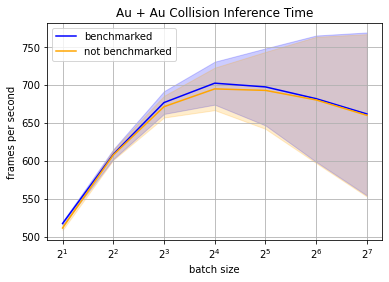

In [37]:
def process(df, x, y, std):
    x = df[x]
    y = df[y]
    y1, y2 = y - df[std], y + df[std]
    return x, y, y1, y2

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

for df, color, legend in zip([df_benchmarked, df_nobenchmarked], ['blue', 'orange'], ['benchmarked', 'not benchmarked']):
    x, y, y1, y2 = process(df, 'batch_size', 'frames per second', 'std')
    ax.plot(x, y, color=color, label=legend)
    ax.fill_between(x, y1=y1, y2=y2, color=color, alpha=.2)
ax.set_xscale('log', base=2)
plt.xlabel('batch size')
plt.ylabel('frames per second')
plt.title('Au + Au Collision Inference Time')
plt.grid()
plt.legend(loc='upper left')
save_fname='results/inference_time_noloader.png'
plt.savefig(save_fname, bbox_inches='tight', dpi=200)

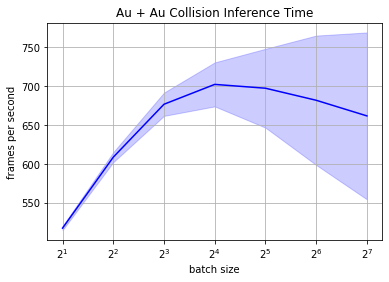

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
x, y, y1, y2 = process(df_benchmarked, 'batch_size', 'frames per second', 'std')
ax.plot(x, y, color='blue', label=legend)
ax.fill_between(x, y1=y1, y2=y2, color='blue', alpha=.2)
ax.set_xscale('log', base=2)
plt.xlabel('batch size')
plt.ylabel('frames per second')
plt.title('Au + Au Collision Inference Time')
plt.grid()
# plt.legend(loc='upper left')
save_fname='results/inference_time_noloader.png'
plt.savefig(save_fname, bbox_inches='tight', dpi=200)